### Импорт библиотек

In [ ]:
!pip install git+https://github.com/wenet-e2e/wespeaker.git

In [1]:
import wespeaker
import os
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.compliance.kaldi as kaldi
from tqdm import tqdm
import pandas as pd

In [2]:
with zipfile.ZipFile('/content/age_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

with zipfile.ZipFile('/content/voxblink2_samresnet34.zip', 'r') as zip_ref:
    zip_ref.extractall('model')

### Функции для получения активаций

In [3]:
class ActivationDataset(Dataset):
    def __init__(self, activations, labels):
        self.X = self.pad_activations(activations)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    def pad_activations(self, activations):
        activations = [act.view(1, -1) if len(act.shape) != 2 else act for act in activations]
        max_len = max(act.shape[1] for act in activations)

        padded_activations = [
            torch.nn.functional.pad(act, (0, max_len - act.shape[1]))
            for act in activations
        ]

        return torch.stack(padded_activations).squeeze(1)

In [4]:
class GetActivations(nn.Module):
    """
    Class for getting activations from a model.
    """

    def __init__(self, model):
        super(GetActivations, self).__init__()
        self.model = model

    def forward(self, x):
        out = x.permute(0, 2, 1)
        activations = []
        model_front = self.model.model.front

        x = out.unsqueeze(dim=1)

        out = model_front.relu(model_front.bn1(model_front.conv1(x)))
        activations.append({"first relu": out})

        for name, layer in model_front.named_children():
            c_sim = 0
            c_relu = 0
            if name in ['layer1', 'layer2', 'layer3', 'layer4']:
                for sec_name, sec_layer in layer.named_children():
                    identity = out

                    out = sec_layer.relu(sec_layer.bn1(sec_layer.conv1(out)))
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

                    out = sec_layer.bn2(sec_layer.conv2(out))
                    out = sec_layer.SimAM(out)
                    c_sim += 1
                    activations.append({f"{name} SimAM {c_sim}": out})

                    if sec_layer.downsample is not None:
                        identity = sec_layer.downsample(identity)

                    out += identity
                    out = sec_layer.relu(out)
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

        out = self.model.model.pooling(out)
        activations.append({"pooling": out})

        if self.model.model.drop:
            out = self.model.model.drop(out)

        out = self.model.model.bottleneck(out)

        return activations, out

In [5]:
class AgeCls(nn.Module):
    """
    Model class for gender classification
    """

    def __init__(self, input_size, num_classes=8):
        super(AgeCls, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

In [6]:
def compute_fbank(wavform,
                  sample_rate=16000,
                  num_mel_bins=80,
                  frame_length=25,
                  frame_shift=10,
                  cmn=True):
    feat = kaldi.fbank(wavform,
                       num_mel_bins=num_mel_bins,
                       frame_length=frame_length,
                       frame_shift=frame_shift,
                       sample_frequency=sample_rate)
    if cmn:
        feat = feat - torch.mean(feat, 0)
    return feat

In [7]:
resample_rate = 16000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_feature_from_pcm(pcm: torch.Tensor, sample_rate: int):
    pcm = pcm.to(torch.float)
    if sample_rate != resample_rate:
        pcm = torchaudio.transforms.Resample(
            orig_freq=sample_rate, new_freq=resample_rate)(pcm)
    feats = compute_fbank(pcm,
                          sample_rate=resample_rate,
                          cmn=True)
    feats = feats.unsqueeze(0)
    feats = feats.to(device)

    return feats

In [8]:
def extract_features(pcm: torch.Tensor, sample_rate: int):
    return extract_feature_from_pcm(pcm, sample_rate)

In [9]:
def get_activations(model, audio_path, device, target_samples=16000):
    """
    Gets model activations.
    """
    waveform, sr = torchaudio.load(audio_path)

    if waveform.shape[1] > target_samples:
        waveform = waveform[:, :target_samples]
    else:
        padding = target_samples - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))

    feats = extract_features(waveform, sr)

    with torch.no_grad():
        activations = model(feats)

    return {
        'file_path': str(audio_path),
        'act': activations[0] if isinstance(activations, tuple) else activations
    }

In [10]:
def get_activations_for_layer(model, audio_files, device,
                              layer_name, labels, target_samples=16000):
    """
    Gets model activations for a specified layer.
    """
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    activations = []
    with torch.no_grad():
        for audio_input in tqdm(audio_files, desc=f"Extracting {layer_name}"):
            waveform, sr = torchaudio.load(str(audio_input))
            if waveform.shape[1] > target_samples:
                waveform = waveform[:, :target_samples]
            else:
                padding = target_samples - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))
            feats = extract_features(waveform, sr)

            feats = feats.to(device)
            acts, _ = model(feats)

            activation = next((d[layer_name] for d in acts if layer_name in d), None)
            if activation is not None:
                activations.append(activation.cpu())

    return activations, labels

In [11]:
def train(train_loader, input_size, layer, device, num_epochs=10):
    """
    Train a model on a train dataset
    """
    model = AgeCls(input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        model.train()

        for X, y in train_loader:
            X = X.to(device)

            outputs = model(X)
            loss = criterion(outputs, y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

In [12]:
def evaluate(model, test_loader, device):
    """
    Evaluates a model on a test dataset.
    Calculates accuracy and f1-score
    """
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in tqdm(
                test_loader, desc="Evaluation Progress"):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(axis=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred, average="weighted")
    }

    return metrics

In [13]:
def plot_metrics(metrics_list, save_path):
    layers = [m[0] for m in metrics_list]
    accuracies = [m[1]["accuracy"] for m in metrics_list]
    f1_scores = [m[1]["f1_score"] for m in metrics_list]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(layers)+1), accuracies, color='b', label="Accuracy")
    plt.xlabel("Layers")
    plt.ylabel("Accuracy")
    plt.title("Accuracy across layers")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(layers)+1), f1_scores, color='g', label="F1-score")
    plt.xlabel("Layers")
    plt.ylabel("F1-score")
    plt.title("F1-score across layers")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)

In [14]:
def save_metrics(metrics_list, save_path):
    """
    Saves computed metrics in .txt file
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    with open(save_path, 'w') as f:
        for layer, metrics in metrics_list:
            f.write(f"{layer}\n")
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

### Получение активаций

In [15]:
df_train = pd.read_csv("/content/dataset/train.csv")
df_test = pd.read_csv("/content/dataset/test.csv")

In [16]:
df_train["filename"] = "/content/dataset/" + df_train["filename"]
df_test["filename"] = "/content/dataset/" + df_test["filename"]

In [17]:
train_files = df_train["filename"].to_list()
test_files = df_test["filename"].to_list()

train_labels = df_train["age"].to_list()
test_labels = df_test["age"].to_list()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = wespeaker.load_model_local("/content/model/voxblink2_samresnet34")
model.set_device(device)

acts_model = GetActivations(model)
acts = get_activations(acts_model, train_files[0], device)
layers = [list(item.keys())[0] for item in acts['act']]

In [21]:
metrics_list = []

for layer in layers:
    train_acts, train_labels = get_activations_for_layer(
        acts_model, train_files, device, layer, train_labels)
    test_acts, test_labels = get_activations_for_layer(
        acts_model, test_files, device, layer, test_labels)

    train_dataset = ActivationDataset(train_acts, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    test_dataset = ActivationDataset(test_acts, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    trained_model = train(
        train_loader, train_dataset.X.shape[-1], layer, device)
    torch.save(trained_model.state_dict(),
                f"/content/models_test/{layer}.pth")
    metrics = evaluate(trained_model, test_loader, device)

    metrics_list.append((layer, metrics))

    torch.cuda.empty_cache()

Evaluation Progress: 100%|██████████| 15/15 [00:00<00:00, 1137.70it/s]


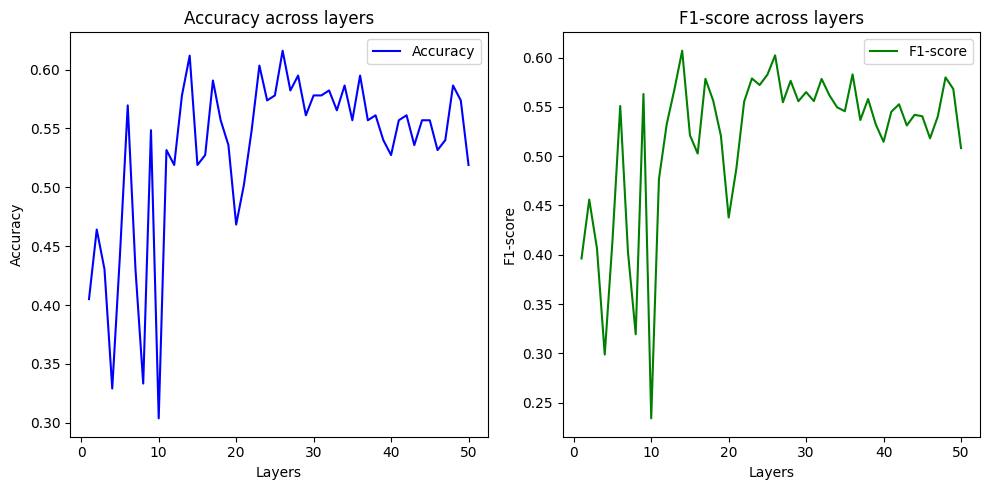

In [22]:
save_metrics(metrics_list, '/content/result/probing.txt')
plot_metrics(metrics_list, '/content/result/probing.png')